# Import Libraries

In [19]:
import os
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from albumentations import HorizontalFlip, Normalize, Compose
from albumentations.pytorch import ToTensorV2
from skimage import io, transform

# Define Constants

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATASET_FOLDER = './dataset/'

# Hyperparameters
BATCH_SIZE = 10
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
CHECKPOINT_PATH = './checkpoint'
BEST_MODEL_PATH = './best_model.pt'

# Download Dataset

In [3]:
!rm -rf *

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alimtegar","key":"72a6e6eff45a4912e2b26ee965d1b187"}'}

In [5]:
!rm -rf ~/.kaggle/
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c data-science-bowl-2018

 96% 343M/358M [00:02<00:00, 170MB/s]
100% 358M/358M [00:02<00:00, 136MB/s]


In [7]:
!unzip data-science-bowl-2018.zip

Archive:  data-science-bowl-2018.zip
  inflating: stage1_sample_submission.csv.zip  
  inflating: stage1_solution.csv.zip  
  inflating: stage1_test.zip         
  inflating: stage1_train.zip        
  inflating: stage1_train_labels.csv.zip  
  inflating: stage2_sample_submission_final.csv.zip  
  inflating: stage2_test_final.zip   


In [8]:
!unzip stage1_train.zip -d $DATASET_FOLDER

Streaming output truncated to the last 5000 lines.
  inflating: ./dataset/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/160cf18b03df69978e2ed33335afcd781ebebf4ee42df566aaa6fd0aee66ac93.png  
  inflating: ./dataset/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/16d3bf2426e9cda0e4f435de3a0c260d17be460f1c834c1282dfd68f9fcf7509.png  
  inflating: ./dataset/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1cfe69ef1dec8963e05ba8386a956af0073ba0bec2cc8ba534df81ef6dee905a.png  
  inflating: ./dataset/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1d2543cd2a8134ac2ca091a230bd15270826f8dd83c6594550b7f0fc85a15f8e.png  
  inflating: ./dataset/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/24b50e6e3406e513d47ddfa9bd85505a95a266858cffc730a9ad7bc99936b800.png  
  inflating: ./dataset/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/341193ff7f035f118eabe993464e40

# Load Dataset

In [9]:
def get_transforms(mean, std):
    transforms_list = []
    transforms_list.extend([HorizontalFlip(p=0.5)])
    transforms_list.extend([Normalize(mean=mean, std=std, p=1),
                            ToTensorV2()])
    transform_list_composed = Compose(transforms_list)
    return transform_list_composed

class NuclieDataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.folders = os.listdir(path)
        self.transforms = get_transforms(0.5, 0.5)

    def __len__(self):
        return len(self.folders)
    
    def __getitem__(self, idx):
        image_folder = os.path.join(self.path, self.folders[idx], 'images/')
        mask_folder = os.path.join(self.path, self.folders[idx], 'masks/')
        image_path = os.path.join(image_folder, os.listdir(image_folder)[0])

        image = io.imread(image_path)[:, :, :3].astype('float32')
        image = transform.resize(image, (128, 128))

        mask = self.get_mask(mask_folder, 128, 128).astype('float32')

        data_transformed = self.transforms(image=image, mask=mask)
        image = data_transformed['image']
        mask = data_transformed['mask']
        mask = mask.permute(2, 0, 1)

        return (image, mask)

    def get_mask(self, mask_folder, IMAGE_HEIGHT, IMAGE_WIDTH):
        mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=bool)
        for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder, mask_))
            mask_ = transform.resize(mask_, (IMAGE_HEIGHT, IMAGE_WIDTH))
            mask_ = np.expand_dims(mask_, axis=-1)
            mask = np.maximum(mask, mask_)
        return mask

In [10]:
dataset = NuclieDataset(DATASET_FOLDER)
print('Dataset length: ', dataset.__len__())
print('Dataset sample: ', dataset.__getitem__(0))

Dataset length:  670
Dataset sample:  (tensor([[[-0.9621, -0.9640, -0.9620,  ..., -0.8322, -0.8981, -0.9459],
         [-0.9634, -0.9618, -0.9620,  ..., -0.8192, -0.8747, -0.9356],
         [-0.9613, -0.9616, -0.9620,  ..., -0.8238, -0.8697, -0.9325],
         ...,
         [-0.7191, -0.7285, -0.7480,  ..., -0.9581, -0.9557, -0.9576],
         [-0.7163, -0.7352, -0.7459,  ..., -0.9554, -0.9553, -0.9562],
         [-0.7183, -0.7402, -0.7456,  ..., -0.9566, -0.9569, -0.9585]],

        [[-0.9621, -0.9640, -0.9620,  ..., -0.8322, -0.8981, -0.9459],
         [-0.9634, -0.9618, -0.9620,  ..., -0.8192, -0.8747, -0.9356],
         [-0.9613, -0.9616, -0.9620,  ..., -0.8238, -0.8697, -0.9325],
         ...,
         [-0.7191, -0.7285, -0.7480,  ..., -0.9581, -0.9557, -0.9576],
         [-0.7163, -0.7352, -0.7459,  ..., -0.9554, -0.9553, -0.9562],
         [-0.7183, -0.7402, -0.7456,  ..., -0.9566, -0.9569, -0.9585]],

        [[-0.9621, -0.9640, -0.9620,  ..., -0.8322, -0.8981, -0.9459],
      

In [11]:
for image, mask in dataset:
    print('Image shape: ', image.shape)
    print('Mask shape: ', mask.shape)
    break

Image shape:  torch.Size([3, 128, 128])
Mask shape:  torch.Size([1, 128, 128])


In [12]:
def convert_image(image):
    std = np.array((0.5, 0.5, 0.5))
    mean = np.array((0.5, 0.5, 0.5))

    image = image.clone().cpu().numpy()
    image = image.transpose((1, 2, 0))
    image = std * image + mean
    image = image.clip(0, 1)
    image = (image * 255).astype(np.uint8)
    return image

def convert_mask(mask):
    std = np.array((0.5))
    mean = np.array((0.5))

    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1, 2, 0))
    mask = std * mask + mean
    mask = mask.clip(0, 1)
    mask = np.squeeze(mask)
    return mask

def plot_image(n, loader):
    iter_ = iter(loader)
    
    images, masks = next(iter_)
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    plt.figure(figsize=(10, 6))
    for idx in range(0, n):
        image = convert_image(images[idx])
        plt.subplot(2, n, idx+1)
        plt.title('Image')
        plt.imshow(image)
    for idx in range(0, n):
        mask = convert_mask(masks[idx])
        plt.subplot(2, n, idx+n+1)
        plt.title('Mask')
        plt.imshow(mask)
    plt.show()

In [13]:
train_set, val_set = random_split(dataset, (580, 90))
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE)

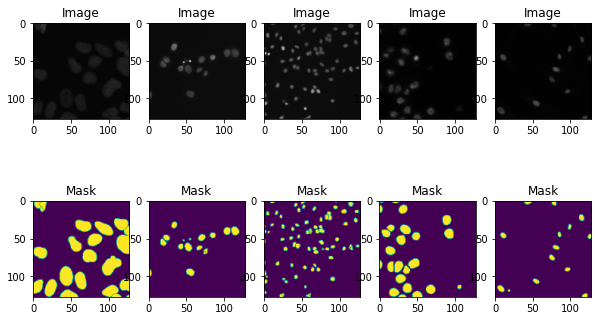

In [14]:
plot_image(5, train_loader)

# Define Model and Loss Function

In [15]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of the UNet
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of the UNet
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Down part path
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Up part path
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = F.pad(x, (0, skip_connection.shape[3] - x.shape[3],
                                          0, skip_connection.shape[2] - x.shape[2]))
            
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        
        return self.final_conv(x)

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
    
    def forward(self, inputs, targets, smooth=1):
        bce_weight = 0.5
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = 1 - (2. * intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        bce = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss = bce*bce_weight + dice*(1 - bce_weight)
        return loss

def get_iou(y_pred, y, smooth=1):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection
    iou = (intersection + smooth)/(union + smooth)
    return iou

def get_iou_batch(y_pred, y):
    ious = []

    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.clone().cpu().detach().numpy()
    y = y.clone().cpu().detach().numpy()

    for pred, label in zip(y_pred, y):
        ious.append(get_iou(pred, label))

    iou = np.nanmean(ious)
    return iou

In [24]:
def save_checkpoint(state, is_best, checkpoint_path, best_model_path):
    torch.save(state, checkpoint_path)
    if is_best:
        shutil.copyfile(checkpoint_path, best_model_path)
        
def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    val_loss_min = checkpoint['val_loss_min']
    return model, optimizer, checkpoint['epoch'], val_loss_min.item()

# Train Model

In [17]:
model = UNet().to(DEVICE)
criterion = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [20]:
val_loss_min = 3.95275
train_loss, val_loss = [], []
train_iou, val_iou = [], []
for epoch in range(NUM_EPOCHS):
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS}')
    
    start_time = time.time()

    running_train_loss = []
    running_train_score = []
    for image, mask in train_loader:
        image = image.to(DEVICE, dtype=torch.float)
        mask = mask.to(DEVICE, dtype=torch.float)

        # Forward
        mask_pred = model.forward(image)
        loss = criterion(mask_pred, mask)
        score = get_iou_batch(mask_pred, mask)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss.append(loss.item())
        running_train_score.append(score)
    else:
        running_val_loss = []
        running_val_score = []
        with torch.no_grad():
            for image, mask in val_loader:
                image = image.to(DEVICE, dtype=torch.float)
                mask = mask.to(DEVICE, dtype=torch.float)

                # Forward
                mask_pred = model.forward(image)
                loss = criterion(mask_pred, mask)
                score = get_iou_batch(mask_pred, mask)

                running_val_loss.append(loss.item())
                running_val_score.append(score)


    epoch_train_loss, epoch_train_score = np.mean(running_train_loss), np.mean(running_train_score)
    print(f'Train loss: {epoch_train_loss}, IoU: {epoch_train_score}')
    train_loss.append(epoch_train_loss)
    train_iou.append(epoch_train_score)

    epoch_val_loss, epoch_val_score = np.mean(running_val_loss), np.mean(running_val_score)
    print(f'Validation loss: {epoch_val_loss}, IoU: {epoch_val_score}')
    val_loss.append(epoch_val_loss)
    val_iou.append(epoch_val_score)

    checkpoint = {
        'epoch': epoch + 1,
        'val_loss_min': val_loss_min,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    save_checkpoint(checkpoint, False, CHECKPOINT_PATH, BEST_MODEL_PATH)

    if epoch_val_loss <= val_loss_min:
        print(f'Validation loss decreased ({val_loss_min:.6f} -> {epoch_val_loss:.6f}). Saving model...')
        save_checkpoint(checkpoint, True, CHECKPOINT_PATH, BEST_MODEL_PATH)
        val_loss_min = epoch_val_loss
    
    time_elapsed = time.time() - start_time
    print(f'{(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')

Epoch: 1/10
Train loss: 0.2206166443125955, IoU: 0.47704823804531593
val loss: 0.18358093582921559, IoU: 0.5421337926109874
Validation loss decreased (3.952750 -> 0.183581). Saving model...
16m 8s
Epoch: 2/10
Train loss: 0.17207038582398973, IoU: 0.577993187633061
val loss: 0.14583395338720745, IoU: 0.6104267308318916
Validation loss decreased (0.183581 -> 0.145834). Saving model...
16m 10s
Epoch: 3/10
Train loss: 0.16258335280521163, IoU: 0.6152686195454429
val loss: 0.1516878455877304, IoU: 0.6224622286818474
15m 49s
Epoch: 4/10
Train loss: 0.18254497814281234, IoU: 0.6043467226864142
val loss: 0.14076079262627494, IoU: 0.6478286836880538
Validation loss decreased (0.145834 -> 0.140761). Saving model...
15m 58s
Epoch: 5/10
Train loss: 0.1535097323358059, IoU: 0.6464831297069964
val loss: 0.13067249208688736, IoU: 0.6723936162929696
Validation loss decreased (0.140761 -> 0.130672). Saving model...
16m 6s
Epoch: 6/10
Train loss: 0.15112283299195356, IoU: 0.660041990166109
val loss: 0.1

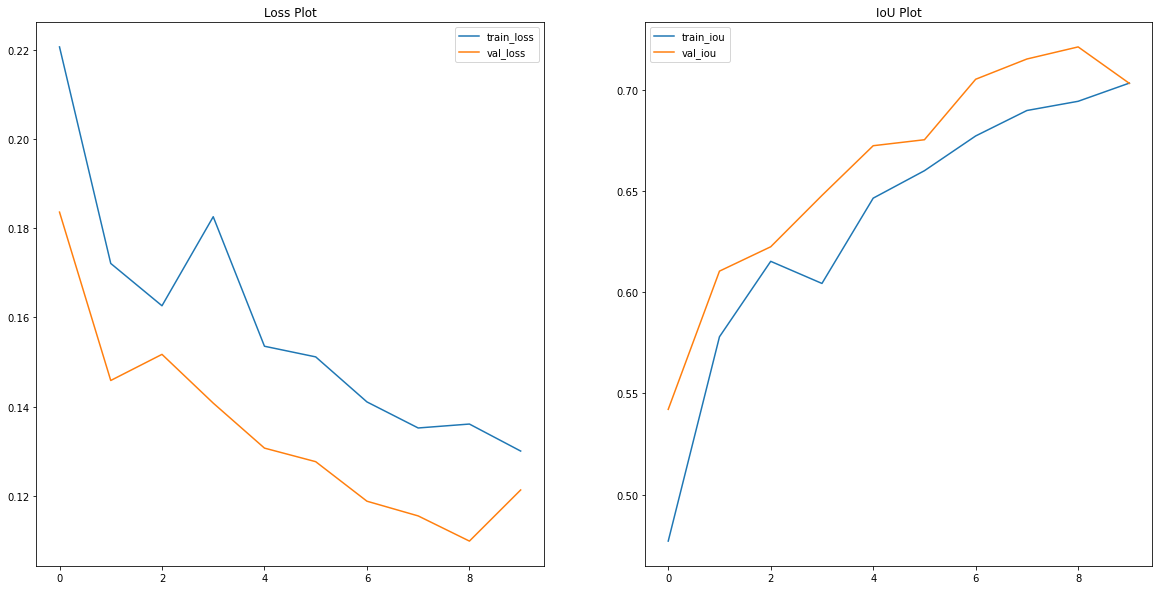

In [23]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.subplot(1, 2, 2)
plt.plot(train_iou, label='train_iou')
plt.plot(val_iou, label='val_iou')
plt.legend()
plt.title('IoU Plot')
plt.show()

# Test Model

In [25]:
model, optimizer, start_epoch, val_loss_min = load_checkpoint(CHECKPOINT_PATH, model, optimizer)

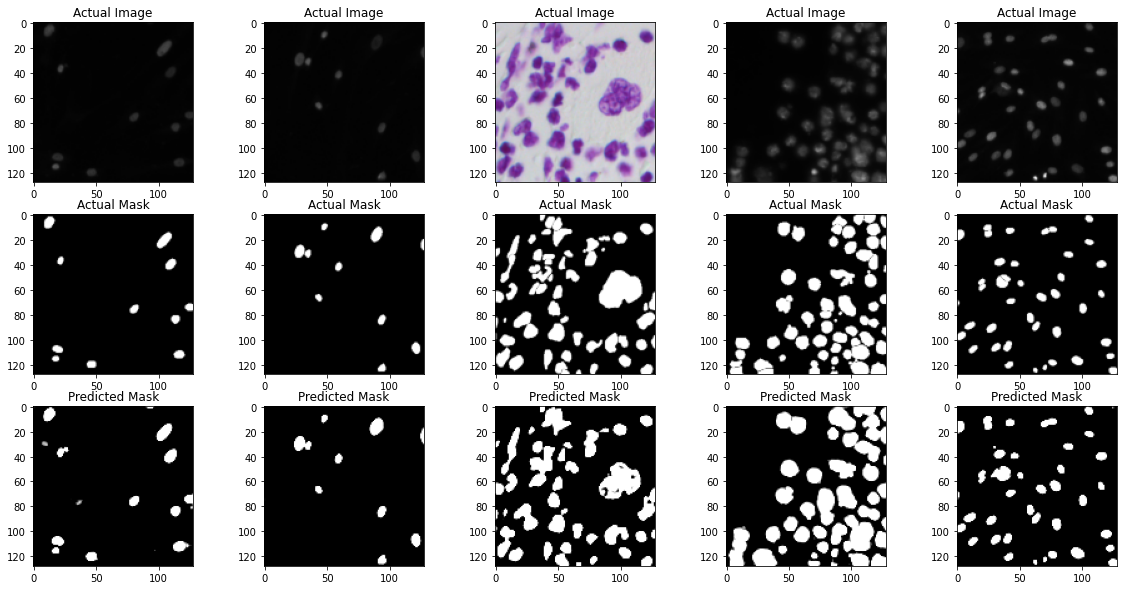

In [29]:
iter_ = iter(val_loader)
image, mask = next(iter_)
image = image.to(DEVICE, dtype=torch.float)
mask = mask.to(DEVICE, dtype=torch.float)

y_pred = model.forward(image)

plt.figure(figsize=(20,10))
for i in range(0, 5):
    plt.subplot(3, 5, i+1)
    plt.title('Actual Image')
    plt.imshow(convert_image(image[i]))
for i in range(0, 5):
    plt.subplot(3, 5, i+5+1)
    plt.title('Actual Mask')
    plt.imshow(convert_mask(mask[i]), cmap='gray')
for i in range(0, 5):
    plt.subplot(3, 5, i+10+1)
    plt.title('Predicted Mask')
    plt.imshow(convert_mask(y_pred[i]), cmap='gray')
plt.show()

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Save Model

In [34]:
!mkdir /content/drive/My\ Drive/models/nuclei_semantic_segmentation/
!cp best_model.pt /content/drive/My\ Drive/models/nuclei_semantic_segmentation/best_model.pt
!cp checkpoint /content/drive/My\ Drive/models/nuclei_semantic_segmentation/checkpoint

mkdir: cannot create directory ‘/content/drive/My Drive/models/nuclei_semantic_segmentation/’: File exists
